# Reds Baseball Analytics 2024 Hackathon

by Adi Krish, Prasheeth Venkat, Vrishank Gosh

## Data Ingestion

In [ ]:
fangraphs_data = pd.read_csv("fangraphs_season_level.csv")
savant_data = pd.read_csv("savant_pitch_level.csv")

In [ ]:
# Define thresholds
threshold_g_MR = 21  # 50th percentile
threshold_gs_MR = 1  # Slightly above minimum
min_ip_MR = 16.1     # 25th percentile
max_ip_MR = 112.1    # 75th percentile
threshold_percentage_LS = 0.75  # Hypothetical value, adjust based on your analysis
threshold_gmli_SU = 0.955314  # 75th percentile
threshold_hld_SU = 1          # 75th percentile

threshold_sv_CL = 20  # High number of saves for Closers
min_ip_LR = 40        # Minimum innings pitched for Long Relievers
balance_threshold_SW = 0.3  # Minimum balance ratio of GS to (G-GS) for Swingmen



# Closer
def is_closer(row):
    return row['SV'] > threshold_sv_CL

# Long Reliever
def is_long_reliever(row):
    return (row['IP'] > min_ip_LR) and not is_middle_reliever(row)

# Swingman
def is_swingman(row):
    return row['GS'] / max(row['G'] - row['GS'], 1) > balance_threshold_SW

# Middle Reliever
def is_middle_reliever(row):
    return row['G'] > threshold_g_MR and row['GS'] < threshold_gs_MR and min_ip_MR <= row['IP'] <= max_ip_MR

# Lefty Specialist
def is_lefty_specialist(player_id):
    left_handed_batters_faced = savant_data[savant_data['stand'] == 'L'].groupby('pitcher').size().get(player_id, 0)
    total_batters_faced = savant_data.groupby('pitcher').size().get(player_id, 1)  # avoid division by zero
    percentage_left_handed_batters_faced = left_handed_batters_faced / total_batters_faced
    return percentage_left_handed_batters_faced > threshold_percentage_LS

# Setup Man
def is_setup_man(row):
    return row['gmLI'] > threshold_gmli_SU and row['HLD'] > threshold_hld_SU

fangraphs_data['additional_role'] = fangraphs_data.apply(
    lambda row: 'Middle Reliever' if is_middle_reliever(row) else
                'Lefty Specialist' if is_lefty_specialist(row['MLBAMID']) else
                'Setup Man' if is_setup_man(row) else
                'Closer' if is_closer(row) else
                'Long Reliever' if is_long_reliever(row) else
                'Swingman' if is_swingman(row) else
                'Other', axis=1)

# Review the categorization
print(fangraphs_data['additional_role'].value_counts())


In [ ]:
#Starting pitcher success analysis
starting_pitchers = fangraphs_data[fangraphs_data['Role'] == 'SP']
metrics_sp = ['IP', 'ERA', 'WHIP', 'K_per_9', 'FIP', 'xFIP', 'WPA', 'LOB_pct']

# Visualizing the distribution of each metric
for metric in metrics_sp:
    plt.figure(figsize=(10, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(starting_pitchers[metric], kde=True)
    plt.title(f'Histogram of {metric}')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=starting_pitchers[metric])
    plt.title(f'Boxplot of {metric}')

    plt.show()

    # Shapiro-Wilk Test
    stat, p = shapiro(starting_pitchers[metric].dropna())
    print(f'Shapiro-Wilk Test for {metric} - Statistics={stat}, p={p}')
    if p > 0.05:
        print('Sample looks Gaussian (normal distribution).')
    else:
        print('Sample does not look Gaussian (not normally distributed).')

    # Compare Mean and Median
    mean_value = starting_pitchers[metric].mean()
    median_value = starting_pitchers[metric].median()
    print(f'Mean for {metric}: {mean_value}')
    print(f'Median for {metric}: {median_value}')
    print('\n---\n')



In [ ]:
sp_metrics_summary = starting_pitchers[['IP', 'ERA', 'WHIP', 'K_per_9', 'FIP', 'xFIP', 'WPA', 'LOB_pct']].median()
sp_ids = starting_pitchers['MLBAMID'].unique()
sp_pitches = savant_data[savant_data['pitcher'].isin(sp_ids)]
sp_pitch_types = sp_pitches.groupby(['pitcher', 'pitch_type']).size().unstack().fillna(0)
sp_velocity = sp_pitches.groupby('pitcher')['release_speed'].mean()
sp_spin_rate = sp_pitches.groupby('pitcher')['release_spin_rate'].mean()


sp_velocity = sp_velocity.reset_index()
sp_spin_rate = sp_spin_rate.reset_index()

sp_velocity = sp_velocity.rename(columns={'pitcher': 'MLBAMID'})
sp_spin_rate = sp_spin_rate.rename(columns={'pitcher': 'MLBAMID'})


starting_pitchers = starting_pitchers.merge(sp_pitch_types, left_on='MLBAMID', right_index=True, how='left')
starting_pitchers = starting_pitchers.merge(sp_velocity, on='MLBAMID', how='left')
starting_pitchers = starting_pitchers.merge(sp_spin_rate, on='MLBAMID', how='left')


In [ ]:
# Define success criteria based on multiple metrics for Starting Pitchers
success_criteria_sp = (
    (starting_pitchers['IP'] >= sp_metrics_summary['IP']) &
    (starting_pitchers['ERA'] <= sp_metrics_summary['ERA']) &
    (starting_pitchers['WHIP'] <= sp_metrics_summary['WHIP']) &
    (starting_pitchers['K_per_9'] >= sp_metrics_summary['K_per_9']) &
    (starting_pitchers['FIP'] <= sp_metrics_summary['FIP']) &
    (starting_pitchers['xFIP'] <= sp_metrics_summary['xFIP']) &
    (starting_pitchers['WPA'] >= sp_metrics_summary['WPA']) &
    (starting_pitchers['LOB_pct'] >= sp_metrics_summary['LOB_pct'])
)
# Filter successful and less successful Starting Pitchers
successful_sp = starting_pitchers[success_criteria_sp]
less_successful_sp = starting_pitchers[~success_criteria_sp]

metrics_sp = ['IP', 'ERA', 'WHIP', 'K_per_9', 'FIP', 'xFIP', 'WPA', 'LOB_pct']


for metric in metrics_sp:
    median_successful = successful_sp[metric].median()
    median_less_successful = less_successful_sp[metric].median()
    print(f"Median {metric} for successful SP: {median_successful}")
    print(f"Median {metric} for less successful SP: {median_less_successful}")
    print('\n---\n')


In [ ]:
for metric in metrics_sp:
    stat, p = ttest_ind(successful_sp[metric].dropna(), less_successful_sp[metric].dropna())
    print(f"{metric}: Statistics={stat}, p-value={p}")

In [ ]:
relief_pitchers = fangraphs_data[fangraphs_data['Role'] == 'RP']
metrics_rp = ['SV', 'HLD', 'ERA', 'WHIP', 'K_per_9', 'BB_per_9', 'WPA']
for metric in metrics_rp:
    plt.figure(figsize=(10, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(relief_pitchers[metric], kde=True)
    plt.title(f'Histogram of {metric}')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=relief_pitchers[metric])
    plt.title(f'Boxplot of {metric}')

    plt.show()

    # Shapiro-Wilk Test
    stat, p = shapiro(relief_pitchers[metric].dropna())
    print(f'Shapiro-Wilk Test for {metric} - Statistics={stat}, p={p}')
    if p > 0.05:
        print('Sample looks Gaussian (normal distribution).')
    else:
        print('Sample does not look Gaussian (not normally distributed).')

    # Compare Mean and Median
    mean_value = relief_pitchers[metric].mean()
    median_value = relief_pitchers[metric].median()
    print(f'Mean for {metric}: {mean_value}')
    print(f'Median for {metric}: {median_value}')
    print('\n---\n')


In [ ]:
rp_metrics_summary = relief_pitchers[metrics_rp].median()


# Get unique MLBAM IDs for Relief Pitchers
rp_ids = relief_pitchers['MLBAMID'].unique()

# Filter the savant_data for pitches thrown by Relief Pitchers
rp_pitches = savant_data[savant_data['pitcher'].isin(rp_ids)]

# Group by pitcher and pitch type, count pitches of each type for each pitcher
rp_pitch_types = rp_pitches.groupby(['pitcher', 'pitch_type']).size().unstack().fillna(0)

# Calculate average velocity and spin rate for each Relief Pitcher
rp_velocity = rp_pitches.groupby('pitcher')['release_speed'].mean()
rp_spin_rate = rp_pitches.groupby('pitcher')['release_spin_rate'].mean()

# Reset index to turn the series into DataFrame
rp_velocity = rp_velocity.reset_index()
rp_spin_rate = rp_spin_rate.reset_index()

# Rename columns for consistency
rp_velocity = rp_velocity.rename(columns={'pitcher': 'MLBAMID'})
rp_spin_rate = rp_spin_rate.rename(columns={'pitcher': 'MLBAMID'})

# Merge pitch type counts, average velocity, and average spin rate with the relief_pitchers DataFrame
relief_pitchers = relief_pitchers.merge(rp_pitch_types, left_on='MLBAMID', right_index=True, how='left')
relief_pitchers = relief_pitchers.merge(rp_velocity, on='MLBAMID', how='left')
relief_pitchers = relief_pitchers.merge(rp_spin_rate, on='MLBAMID', how='left')


In [ ]:
# Convert column index to a list and print
column_names = relief_pitchers.columns.tolist()
print(column_names)



In [ ]:
# Define success criteria here
rp_metrics_summary = relief_pitchers[['SV_x', 'HLD', 'ERA', 'WHIP', 'K_per_9', 'BB_per_9', 'WPA']].median().rename('median')

# Define success criteria based on multiple metrics for Relief Pitchers
success_criteria_rp = (
    (relief_pitchers['ERA'] <= rp_metrics_summary['ERA']) &
    (relief_pitchers['WHIP'] <= rp_metrics_summary['WHIP']) &
    (relief_pitchers['SV_x'] >= rp_metrics_summary['SV_x']) &
    (relief_pitchers['HLD'] >= rp_metrics_summary['HLD']) &
    (relief_pitchers['K_per_9'] >= rp_metrics_summary['K_per_9']) &
    (relief_pitchers['BB_per_9'] <= rp_metrics_summary['BB_per_9']) &
    (relief_pitchers['WPA'] >= rp_metrics_summary['WPA'])
)

# Filter successful and less successful Relief Pitchers
successful_rp = relief_pitchers[success_criteria_rp]
less_successful_rp = relief_pitchers[~success_criteria_rp]




# Define the metrics you want to compare. For example:
metrics_rp = ['SV_x', 'HLD', 'ERA', 'WHIP', 'K_per_9', 'BB_per_9', 'WPA']

for metric in metrics_rp:
    median_successful = successful_rp[metric].median()
    median_less_successful = less_successful_rp[metric].median()
    print(f"Median {metric} for successful RP: {median_successful}")
    print(f"Median {metric} for less successful RP: {median_less_successful}")
    print('\n---\n')



In [ ]:
for metric in metrics_rp:
    stat, p = ttest_ind(successful_rp[metric].dropna(), less_successful_rp[metric].dropna())
    print(f"{metric}: Statistics={stat}, p-value={p}")

In [ ]:
less_successful_sp = less_successful_sp.drop_duplicates(subset='Name')
less_successful_rp = less_successful_rp.drop_duplicates(subset='Name')
starting_pitchers = starting_pitchers.drop_duplicates(subset='Name')
relief_pitchers = relief_pitchers.drop_duplicates(subset='Name')


In [ ]:
# Filter less successful SPs
less_successful_sp = starting_pitchers[~success_criteria_sp]

# Count the frequency of each additional role within less successful SPs
additional_role_counts_sp = less_successful_sp['additional_role'].value_counts()

# Create a bar plot to visualize the distribution of additional roles
plt.figure(figsize=(10, 6))
sns.barplot(x=additional_role_counts_sp.index, y=additional_role_counts_sp.values)
plt.title('Distribution of Additional Roles among Less Successful Starting Pitchers')
plt.xlabel('Additional Role')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# List of pitcher names from the provided cluster dataframe
pitcher_names = [
    "Blake Snell", "Brandon Woodruff", "Clayton Kershaw",
    "Gerrit Cole", "Cole Ragans", "Tarik Skubal"
]

selected_pitchers = less_successful_sp[less_successful_sp['Name'].isin(pitcher_names)]



In [ ]:
selected_columns = selected_pitchers[['Name', 'Role', 'additional_role']]
selected_columns

In [1]:
#Necessary Imports and dependencies
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class ProcessPitcherData:
    def load_pitcher_data(self, pitcher_data_file):
        # load pitcher data
        pitcher_data = pd.read_csv(pitcher_data_file)
        return pitcher_data

In [3]:
# file path for pitcher data
pitcher_data_file = 'fangraphs_season_level.csv'

# create instance of ProcessPitcherData class
process_pitcher_data = ProcessPitcherData()

# load pitcher data
pitcher_data = process_pitcher_data.load_pitcher_data(pitcher_data_file)

pitcher_data.head()

,PlayerId,MLBAMID,Name,NameASCII,Throws,Season,Age,Team,Role,G,...,Pit_plus_FC,Stf_plus_FS,Loc_plus_FS,Pit_plus_FS,Stf_plus_FO,Loc_plus_FO,Pit_plus_FO,Stuff_plus,Location_plus,Pitching_plus
0,18,491703,NeftalÃ­ Feliz,Neftali Feliz,R,2021,33,- - -,RP,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.316418,95.123881,95.873134
1,1157,488984,Tommy Hunter,Tommy Hunter,R,2021,34,NYM,RP,3,...,103.100000,NaN,NaN,NaN,NaN,NaN,NaN,86.285556,94.884444,95.112222
2,1159,461865,Andrew Romine,Andrew Romine,R,2021,35,CHC,RP,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.925000,108.425000,99.200000
3,1246,456713,Matt Bush,Matt Bush,R,2021,35,TEX,RP,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124.852174,98.340580,102.611594
4,1247,493603,Adam Ottavino,Adam Ottavino,R,2021,35,BOS,RP,69,...,66.583333,NaN,NaN,NaN,NaN,NaN,NaN,116.269527,94.625394,102.238617


## Data Exploration

In [4]:
# import 
pitcher_delta_df = pd.read_csv('pitcher_delta_grade.csv')

# Drop name column
pitcher_delta_df = pitcher_delta_df.drop(columns=['player_name'])

pitcher_delta_df.head()

,delta_diff,delta_avg,MLBAMID
0,0.012000,-0.085667,663897
1,0.132329,-0.080487,596112
2,0.010583,-0.073286,641525
3,0.054542,-0.072396,600986
4,0.111389,-0.064529,570731


In [5]:
# merge dataframes
# Note: Delta diff is difference of the delta average of just the firt and second half of pitches thrown
pitcher_data = pd.merge(pitcher_data, pitcher_delta_df, on='MLBAMID')

pitcher_data.head()

,PlayerId,MLBAMID,Name,NameASCII,Throws,Season,Age,Team,Role,G,...,Loc_plus_FS,Pit_plus_FS,Stf_plus_FO,Loc_plus_FO,Pit_plus_FO,Stuff_plus,Location_plus,Pitching_plus,delta_diff,delta_avg
0,1157,488984,Tommy Hunter,Tommy Hunter,R,2021,34,NYM,RP,3,...,NaN,NaN,NaN,NaN,NaN,86.285556,94.884444,95.112222,0.037060,0.008007
1,1157,488984,Tommy Hunter,Tommy Hunter,R,2022,35,NYM,RP,18,...,NaN,NaN,NaN,NaN,NaN,95.934758,108.332194,101.498006,0.037060,0.008007
2,1157,488984,Tommy Hunter,Tommy Hunter,R,2023,36,NYM,RP,14,...,NaN,NaN,NaN,NaN,NaN,82.804360,105.339510,100.527793,0.037060,0.008007
3,1157,488984,Tommy Hunter,Tommy Hunter,R,2021,34,NYM,SP,1,...,NaN,NaN,NaN,NaN,NaN,96.164706,114.752941,107.764706,0.037060,0.008007
4,1246,456713,Matt Bush,Matt Bush,R,2021,35,TEX,RP,4,...,NaN,NaN,NaN,NaN,NaN,124.852174,98.340580,102.611594,0.000057,0.014121


In [6]:
print(f"Pitcher data shape: {pitcher_data.shape}")
 
print(f" Number of starting pitchers{pitcher_data[pitcher_data['Role'] == 'SP'].shape}")

print(f" Number of relief pitchers{pitcher_data[pitcher_data['Role'] == 'RP'].shape}")

Pitcher data shape: (2505, 310)
 Number of starting pitchers(947, 310)
 Number of relief pitchers(1558, 310)


## Data Processing

In [7]:
# Filter data to 2023 season
pitcher_data = pitcher_data[pitcher_data['Season'] == 2023]

# Filter to only include number of innings pitched
pitcher_data = pitcher_data[pitcher_data['IP'] > 50]

print(f"Pitcher data shape: {pitcher_data.shape}")

Pitcher data shape: (331, 310)


In [8]:
filtered_pitcher_data = pitcher_data[['Name','ERA', 'K_pct', 'WHIP', 'delta_diff', 'delta_avg', 'Season', 'Role', 'IP']].copy()

filtered_pitcher_data.head()


,Name,ERA,K_pct,WHIP,delta_diff,delta_avg,Season,Role,IP
10,Adam Ottavino,3.210809,0.2375,1.216216,0.069955,-0.044033,2023,RP,61.2
15,Zack Greinke,5.015267,0.1621,1.267176,0.006770,0.006281,2023,SP,131.0
36,Ryan Brasier,3.016758,0.2353,1.022346,0.146894,0.054887,2023,RP,59.2
42,JosÃ© Cisnero,5.308992,0.2622,1.483147,0.008057,0.020210,2023,RP,59.1
45,Craig Kimbrel,3.260870,0.3381,1.043478,0.093141,-0.052338,2023,RP,69.0


In [9]:
# Drop any rows with missing data
filtered_pitcher_data = filtered_pitcher_data.dropna()

print(f"Pitcher data shape: {filtered_pitcher_data.shape}")

filtered_pitcher_data.head()

Pitcher data shape: (331, 9)


,Name,ERA,K_pct,WHIP,delta_diff,delta_avg,Season,Role,IP
10,Adam Ottavino,3.210809,0.2375,1.216216,0.069955,-0.044033,2023,RP,61.2
15,Zack Greinke,5.015267,0.1621,1.267176,0.006770,0.006281,2023,SP,131.0
36,Ryan Brasier,3.016758,0.2353,1.022346,0.146894,0.054887,2023,RP,59.2
42,JosÃ© Cisnero,5.308992,0.2622,1.483147,0.008057,0.020210,2023,RP,59.1
45,Craig Kimbrel,3.260870,0.3381,1.043478,0.093141,-0.052338,2023,RP,69.0


In [10]:
# Split to starting and relief pitchers
sp_pitchers = filtered_pitcher_data[filtered_pitcher_data['Role'] == 'SP'].copy()

rp_pitchers = filtered_pitcher_data[filtered_pitcher_data['Role'] == 'RP'].copy()

print(f" Number of starting pitchers{sp_pitchers.shape}")

print(f" Number of relief pitchers{rp_pitchers.shape}")

 Number of starting pitchers(176, 9)
 Number of relief pitchers(155, 9)


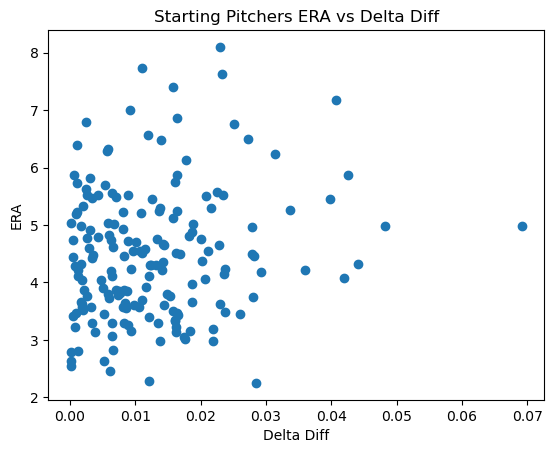

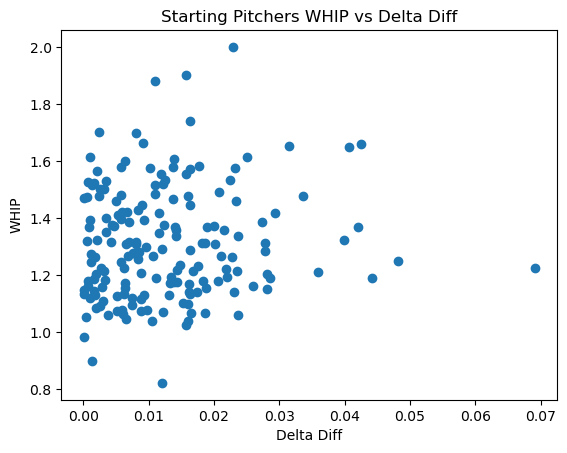

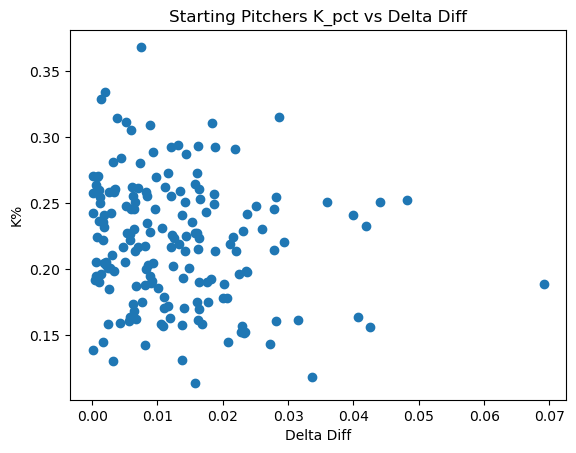

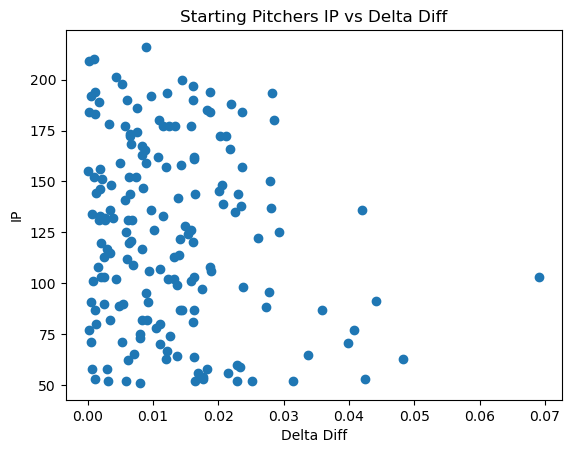

In [11]:
# Compare Starting pitchers ERA vs Delta Diff
plt.scatter(sp_pitchers['delta_diff'], sp_pitchers['ERA'] )
plt.title('Starting Pitchers ERA vs Delta Diff')
plt.xlabel('Delta Diff')
plt.ylabel('ERA')
plt.show()

# Compare Starting pitchers WHIP vs Delta Diff
plt.scatter(sp_pitchers['delta_diff'], sp_pitchers['WHIP'])
plt.title('Starting Pitchers WHIP vs Delta Diff')
plt.xlabel('Delta Diff')
plt.ylabel('WHIP')
plt.show()

# Compare Starting pitchers K_pct vs Delta Diff
plt.scatter(sp_pitchers['delta_diff'], sp_pitchers['K_pct'] )
plt.title('Starting Pitchers K_pct vs Delta Diff')
plt.xlabel('Delta Diff')
plt.ylabel('K%')
plt.show()

# Compare Starting pitchers IP vs Delta Diff
plt.scatter(sp_pitchers['delta_diff'], sp_pitchers['IP'] )
plt.title('Starting Pitchers IP vs Delta Diff')
plt.xlabel('Delta Diff')
plt.ylabel('IP')
plt.show()


In [12]:
# Find right outliers for starting pitchers
# Tony Gonsolin clearly stands here as an outlier even among other low consistency pitchers
sp_right_outliers = sp_pitchers[sp_pitchers['ERA'] < 5]

sp_right_outliers = sp_right_outliers[sp_right_outliers['delta_diff'] > 0.0325]

sp_right_outliers

,Name,ERA,K_pct,WHIP,delta_diff,delta_avg,Season,Role,IP
741,Tony Gonsolin,4.980583,0.1885,1.223301,0.069117,0.031552,2023,SP,103.0
1570,Reese Olson,4.319998,0.2507,1.189090,0.044119,0.017490,2023,SP,91.2
1828,Andrew Heaney,4.082917,0.2322,1.368289,0.041986,0.021455,2023,SP,136.2
1893,Nestor Cortes,4.973687,0.2519,1.247369,0.048180,0.014208,2023,SP,63.1
2433,Bryan Woo,4.209124,0.2507,1.209125,0.035925,0.011314,2023,SP,87.2


## Data Analysis and Model Building

/Users/adi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


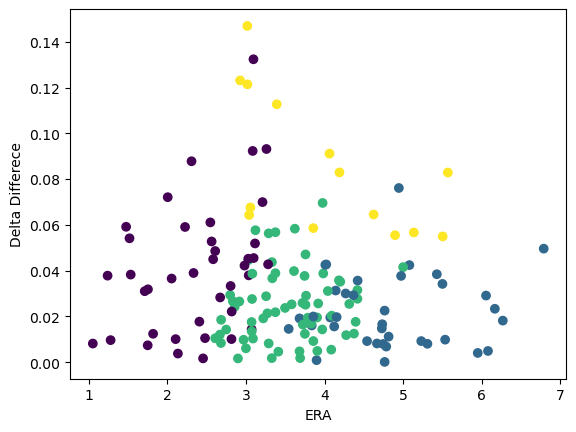

In [13]:
features = rp_pitchers[['ERA', 'K_pct', 'WHIP', 'delta_diff', 'delta_avg']]

# Standardize the data
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Create a kmeans model on our data, using k clusters. Random_state helps ensure that the algorithm returns the same results each time.
model = KMeans(n_clusters=4, random_state=42)

# Use the fit method to fit the model to the features from the dataframe
rp_pitchers['cluster'] = model.fit_predict(scaled_features)

# Create a scatter plot of the data, coloring by cluster
plt.scatter(rp_pitchers['ERA'], rp_pitchers['delta_diff'], c=rp_pitchers['cluster'], cmap='viridis')
plt.xlabel('ERA')
plt.ylabel('Delta Differece')

# Display the plot
plt.show()

### Cluster Analysis and Exploration

In [14]:
# Print value counts for each cluster
print(rp_pitchers['cluster'].value_counts())

cluster
2    65
0    39
1    37
3    14
Name: count, dtype: int64


In [15]:
rp_pitchers[['Name', 'cluster']].head()

,Name,cluster
10,Adam Ottavino,0
36,Ryan Brasier,3
42,JosÃ© Cisnero,1
45,Craig Kimbrel,0
63,Luis GarcÃ­a,1


In [16]:
ohtani_data = sp_pitchers[sp_pitchers['Name'].str.contains('Ohtani')]
ohtani_data

,Name,ERA,K_pct,WHIP,delta_diff,delta_avg,Season,Role,IP
2390,Shohei Ohtani,3.136364,0.3145,1.060606,0.003818,-0.009127,2023,SP,132.0


In [17]:
gerrit_cole_data = sp_pitchers[sp_pitchers['Name'].str.contains('Gerrit')]

gerrit_cole_data

,Name,ERA,K_pct,WHIP,delta_diff,delta_avg,Season,Role,IP
2325,Gerrit Cole,2.626794,0.2704,0.980861,0.000144,-0.013463,2023,SP,209.0


In [18]:
blake_snell_data = sp_pitchers[sp_pitchers['Name'].str.contains('Blake Snell')]
blake_snell_data

,Name,ERA,K_pct,WHIP,delta_diff,delta_avg,Season,Role,IP
2454,Blake Snell,2.25,0.3154,1.188889,0.028536,-0.023045,2023,SP,180.0


#### Explore Clusters

In [19]:
# Explore Cluster 0
cluster_0 = rp_pitchers[rp_pitchers['cluster'] == 0]
cluster_0.describe()

,ERA,K_pct,WHIP,delta_diff,delta_avg,Season,IP,cluster
count,39.000000,39.000000,39.000000,39.000000,39.000000,39.0,39.000000,39.0
mean,2.392811,0.291546,1.046596,0.040962,-0.031403,2023.0,61.746154,0.0
std,0.635969,0.061253,0.106965,0.028616,0.016648,0.0,8.142961,0.0
min,1.051949,0.180000,0.831522,0.001699,-0.080487,2023.0,51.100000,0.0
25%,1.911803,0.243600,0.972043,0.016068,-0.043717,2023.0,54.650000,0.0
50%,2.479593,0.282100,1.041667,0.038288,-0.029485,2023.0,61.000000,0.0
75%,3.005433,0.330550,1.141983,0.053452,-0.021136,2023.0,67.600000,0.0
max,3.281770,0.464100,1.251429,0.132329,0.001372,2023.0,84.100000,0.0


In [20]:
cluster_0.sort_values(by='ERA', ascending=True).head()

,Name,ERA,K_pct,WHIP,delta_diff,delta_avg,Season,Role,IP,cluster
167,Chris Martin,1.051949,0.2312,1.032468,0.008177,-0.039294,2023,RP,51.1,0
900,Brusdar Graterol,1.239797,0.1800,0.979592,0.037828,-0.030753,2023,RP,65.1,0
1800,Josh Hader,1.278107,0.3680,1.100592,0.009668,-0.018375,2023,RP,56.1,0
1245,FÃ©lix Bautista,1.475410,0.4641,0.918033,0.059172,-0.052545,2023,RP,61.0,0
1822,Tim Mayza,1.518751,0.2465,1.218751,0.054143,-0.044487,2023,RP,53.1,0


In [21]:
cluster_1 = rp_pitchers[rp_pitchers['cluster'] == 1]
cluster_1.describe()

,ERA,K_pct,WHIP,delta_diff,delta_avg,Season,IP,cluster
count,37.000000,37.000000,37.000000,37.000000,37.000000,37.0,37.000000,37.0
mean,4.817572,0.231900,1.470333,0.022171,-0.000308,2023.0,59.229730,1.0
std,0.811957,0.045071,0.081772,0.016034,0.013152,0.0,7.337872,0.0
min,3.543752,0.142400,1.360250,0.000152,-0.030337,2023.0,50.100000,1.0
25%,4.142043,0.192300,1.405062,0.009254,-0.010265,2023.0,54.000000,1.0
50%,4.745455,0.244700,1.455446,0.019164,-0.001103,2023.0,58.100000,1.0
75%,5.308992,0.262200,1.529704,0.031335,0.007556,2023.0,63.100000,1.0
max,6.788575,0.325000,1.696429,0.076113,0.023557,2023.0,84.100000,1.0


In [22]:
cluster_1.sort_values(by='ERA', ascending=True).head()

,Name,ERA,K_pct,WHIP,delta_diff,delta_avg,Season,Role,IP,cluster
1973,Cionel PÃ©rez,3.543752,0.1781,1.556251,0.014573,0.006267,2023,RP,53.1,1
236,Derek Law,3.681820,0.1920,1.383118,0.019164,0.005132,2023,RP,51.1,1
1154,Jose Cuas,3.836844,0.2447,1.484211,0.016068,-0.004233,2023,RP,63.1,1
1916,Alex Young,3.857148,0.2119,1.360250,0.019999,0.023557,2023,RP,53.2,1
336,Carlos EstÃ©vez,3.898398,0.2776,1.491979,0.000917,0.002460,2023,RP,62.1,1


In [23]:
# Explore Cluster 2
cluster_2 = rp_pitchers[rp_pitchers['cluster'] == 2]
cluster_2.describe()

,ERA,K_pct,WHIP,delta_diff,delta_avg,Season,IP,cluster
count,65.000000,65.000000,65.000000,65.000000,65.000000,65.0,65.000000,65.0
mean,3.537079,0.256154,1.213725,0.024601,-0.010075,2023.0,62.055385,2.0
std,0.534605,0.039692,0.088683,0.015609,0.013402,0.0,8.048836,0.0
min,2.608696,0.163400,1.014925,0.001669,-0.035513,2023.0,50.100000,2.0
25%,3.081523,0.224700,1.155963,0.012410,-0.019587,2023.0,55.200000,2.0
50%,3.581635,0.258500,1.220339,0.023726,-0.012841,2023.0,61.100000,2.0
75%,3.907892,0.286300,1.285713,0.035177,0.001438,2023.0,66.100000,2.0
max,5.000000,0.335800,1.428001,0.069589,0.013643,2023.0,83.100000,2.0


In [24]:
cluster_2.sort_values(by='ERA', ascending=True).head()

,Name,ERA,K_pct,WHIP,delta_diff,delta_avg,Season,Role,IP,cluster
758,Jason Foley,2.608696,0.1993,1.159420,0.010483,-0.007935,2023,RP,69.0,2
2215,Andrew Nardi,2.668606,0.3080,1.151163,0.012080,-0.014438,2023,RP,57.1,2
2219,Alex Wood,2.682121,0.1667,1.271524,0.008405,0.001048,2023,RP,50.1,2
1101,JosÃ© Leclerc,2.684211,0.2876,1.140351,0.018553,-0.017669,2023,RP,57.0,2
533,Raisel Iglesias,2.748501,0.2944,1.185628,0.014288,-0.013955,2023,RP,55.2,2


In [25]:
# Explore Cluster 3
cluster_3 = rp_pitchers[rp_pitchers['cluster'] == 3]
cluster_3.describe()

,ERA,K_pct,WHIP,delta_diff,delta_avg,Season,IP,cluster
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.0,14.000000,14.0
mean,4.020692,0.258157,1.255210,0.084511,0.038243,2023.0,62.542857,3.0
std,0.981481,0.046998,0.129646,0.030170,0.015934,0.0,6.894448,0.0
min,2.926107,0.166000,1.022346,0.054955,0.013182,2023.0,52.100000,3.0
25%,3.044557,0.235850,1.147035,0.060024,0.022654,2023.0,58.300000,3.0
50%,3.960125,0.257550,1.295117,0.075245,0.042924,2023.0,63.100000,3.0
75%,4.828872,0.284625,1.323729,0.107288,0.052118,2023.0,67.800000,3.0
max,5.568753,0.347400,1.500001,0.146894,0.061797,2023.0,74.000000,3.0


In [26]:
# Sort by ERA
cluster_3.sort_values(by='ERA', ascending=True).head()

,Name,ERA,K_pct,WHIP,delta_diff,delta_avg,Season,Role,IP,cluster
976,Camilo Doval,2.926107,0.3096,1.137930,0.123078,0.052589,2023,RP,67.2,3
36,Ryan Brasier,3.016758,0.2353,1.022346,0.146894,0.054887,2023,RP,59.2,3
2143,Caleb Ferguson,3.018632,0.2754,1.360248,0.121375,0.061797,2023,RP,53.2,3
438,Tyler Rogers,3.040541,0.1942,1.148649,0.064327,0.022109,2023,RP,74.0,3
1346,Matt Brash,3.056607,0.3474,1.330190,0.067619,0.026916,2023,RP,70.2,3


In [27]:
# Find the cluster of right outliers
sp_right_outliers['cluster'] = model.predict(scaler.transform(sp_right_outliers[['ERA', 'K_pct', 'WHIP', 'delta_diff', 'delta_avg']]))
sp_right_outliers

,Name,ERA,K_pct,WHIP,delta_diff,delta_avg,Season,Role,IP,cluster
741,Tony Gonsolin,4.980583,0.1885,1.223301,0.069117,0.031552,2023,SP,103.0,3
1570,Reese Olson,4.319998,0.2507,1.189090,0.044119,0.017490,2023,SP,91.2,2
1828,Andrew Heaney,4.082917,0.2322,1.368289,0.041986,0.021455,2023,SP,136.2,1
1893,Nestor Cortes,4.973687,0.2519,1.247369,0.048180,0.014208,2023,SP,63.1,1
2433,Bryan Woo,4.209124,0.2507,1.209125,0.035925,0.011314,2023,SP,87.2,2


In [28]:
sp_pitchers['cluster'] = model.predict(scaler.transform(sp_pitchers[['ERA', 'K_pct', 'WHIP', 'delta_diff', 'delta_avg']]))

sp_pitchers.head()



,Name,ERA,K_pct,WHIP,delta_diff,delta_avg,Season,Role,IP,cluster
15,Zack Greinke,5.015267,0.1621,1.267176,0.006770,0.006281,2023,SP,131.0,1
60,Chase Anderson,5.754101,0.1751,1.475410,0.016090,0.006810,2023,SP,81.1,1
88,Jordan Lyles,6.281414,0.1604,1.243900,0.005703,0.011692,2023,SP,177.2,1
113,Kyle Gibson,4.734375,0.1945,1.317708,0.000526,0.002900,2023,SP,192.0,1
164,Taijuan Walker,4.378370,0.1883,1.308878,0.020204,-0.005593,2023,SP,172.2,1


In [29]:
sp_cluster_2 = sp_pitchers[sp_pitchers['cluster'] == 2]

sp_cluster_2.sort_values(by='ERA', ascending=True).head(40)

,Name,ERA,K_pct,WHIP,delta_diff,delta_avg,Season,Role,IP,cluster
2457,Max Fried,2.549355,0.2572,1.133047,0.000144,-0.011831,2023,SP,77.2,2
2319,Sonny Gray,2.788043,0.2427,1.146739,0.000123,-0.013689,2023,SP,184.0,2
2411,Kyle Bradish,2.828058,0.2504,1.043476,0.006550,-0.012125,2023,SP,168.2,2
2434,Kodai Senga,2.975958,0.2911,1.220443,0.021808,-0.015829,2023,SP,166.1,2
2432,Tanner Bibee,2.978873,0.2410,1.176056,0.013818,-0.015665,2023,SP,142.0,2
1281,Javier Assad,3.018632,0.1900,1.229813,0.017580,-0.008084,2023,SP,53.2,2
231,Joe Musgrove,3.051371,0.2431,1.140411,0.017437,-0.012110,2023,SP,97.1,2
1865,Justin Steele,3.063468,0.2458,1.171156,0.006431,-0.006521,2023,SP,173.1,2
2390,Shohei Ohtani,3.136364,0.3145,1.060606,0.003818,-0.009127,2023,SP,132.0,2
2092,Wade Miley,3.141283,0.1612,1.138507,0.016178,-0.003713,2023,SP,120.1,2
